### bibliotecas

In [ ]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns


#### dataframe


In [147]:
## devices
path_device = "/home/joyce/lappis/documentacao/docs/engd/data/device_type.json"
with open(path_device, 'r') as file:
    dados_json = json.load(file)
df_devices = pd.DataFrame(dados_json, columns=["label", "nb_visits"])

## region
pat_region = "/home/joyce/lappis/documentacao/docs/engd/data/region.json"
with open(pat_region, 'r') as file:
    dados_json = json.load(file)
df_region = pd.DataFrame(dados_json, columns=["region_name", "country", "nb_visits"])
df_region = df_region[df_region["country"] == "br"]

## visits
path_visits = "/home/joyce/lappis/documentacao/docs/engd/data/visits_over_time.json"
with open(path_visits, 'r') as file:
    dados_json = json.load(file)
lista_dados = []
for data, valores in dados_json.items():
    dados_filtrados = {coluna: valores.get(coluna, None) for coluna in ["nb_uniq_visitors", "nb_visits", "nb_visits_new", "bounce_rate", "nb_visits_returning"]}
    dados_filtrados["data"] = data
    lista_dados.append(dados_filtrados)
df_acessos = pd.DataFrame(lista_dados)
df_acessos = df_acessos[["data", "nb_uniq_visitors", "nb_visits", "nb_visits_new", "bounce_rate", "nb_visits_returning"]]


# decreto
path_decreto = "/home/joyce/lappis/documentacao/docs/engd/data/decreto.json"
with open(path_decreto, 'r') as file:
    dados_json = json.load(file)
df_decreto = pd.DataFrame(dados_json)
contagem_comentarios = df_decreto.groupby("commentable_id").size().reset_index(name="quantidade_comentarios")


## recomendações
recomendacoes_path = "/home/joyce/lappis/documentacao/docs/engd/data/recomendacoes.json"
with open(recomendacoes_path, 'r') as file:
    dados_json = json.load(file)

dados_propostas = []
for proposta in dados_json:
    category_name = proposta["category"]["name"]["pt-BR"]
    title = proposta["title"]["pt-BR"]
    supports = proposta["supports"]
    comments = proposta["comments"]
    dados_propostas.append({
        "category": category_name,
        "title": title,
        "supports": supports,
        "comments": comments
    })

df_recomendacoes = pd.DataFrame(dados_propostas)

#### dados gerais decreto


In [148]:
total_dispositivos = contagem_comentarios["commentable_id"].nunique()
total_comentarios = contagem_comentarios["quantidade_comentarios"].sum()
tabela_markdown = f"| Dispositivos | Comentários |\n|--------------|-------------|\n| {total_dispositivos}          | {total_comentarios}          |"
print(tabela_markdown)

| Dispositivos | Comentários |
|--------------|-------------|
| 41          | 341          |


### dados gerais recomendações

In [149]:
total_recomendacoes = df_recomendacoes["title"].nunique()
total_votos = df_recomendacoes["supports"].sum()
total_comentarios = df_recomendacoes["comments"].sum()

linha_total = pd.DataFrame({
    "Recomendações": [total_recomendacoes],
    "Votos": [total_votos],
    "Comentários": [total_comentarios]
})

tabela_markdown = linha_total[["Recomendações", "Votos", "Comentários"]].to_markdown(index=False)

print(tabela_markdown)


|   Recomendações |   Votos |   Comentários |
|----------------:|--------:|--------------:|
|              49 |    2011 |            41 |


### dados de acesso


In [150]:
caminho_json = "/home/joyce/lappis/documentacao/docs/engd/data/visits_over_time.json"

with open(caminho_json, 'r') as file:
    data = json.load(file)

total_uniq_visitors = 0
total_visits = 0
total_visits_new = 0
total_visits_returning = 0
total_bounce_rate = 0
num_datas = 0

for valores in data.values():
    total_uniq_visitors += valores['nb_uniq_visitors']
    total_visits += valores['nb_visits']
    total_visits_new += valores['nb_visits_new']
    total_visits_returning += valores['nb_visits_returning']
    
    if 'bounce_rate' in valores:
        total_bounce_rate += int(valores['bounce_rate'].strip('%'))
        num_datas += 1

media_bounce_rate = f'{total_bounce_rate / num_datas}%'

df_total = pd.DataFrame({
    'Data': ['Total'],
    'nb_uniq_visitors': total_uniq_visitors,
    'nb_visits': total_visits,
    'nb_visits_new': total_visits_new,
    'bounce_rate': media_bounce_rate,
    'nb_visits_returning': total_visits_returning
})


#### gráficos linhas


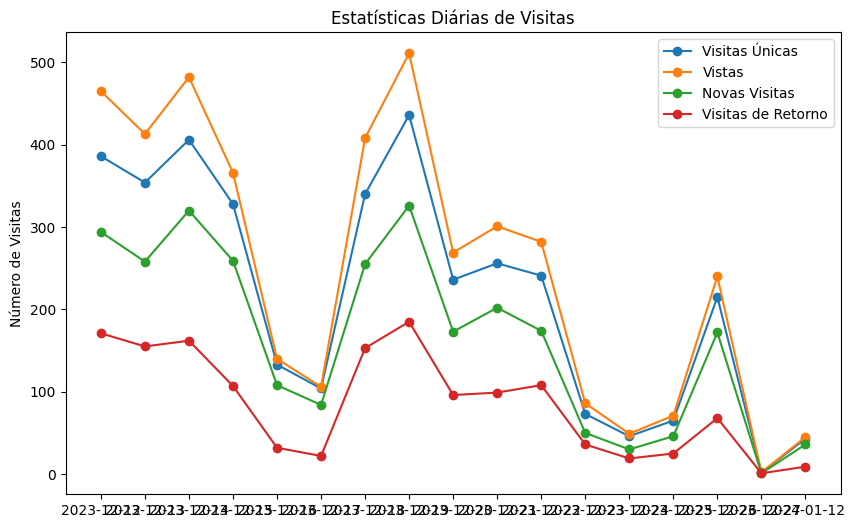

In [175]:

caminho_json = "/home/joyce/lappis/documentacao/docs/engd/data/visits_over_time.json"

with open(caminho_json, 'r') as file:
    dados_json = json.load(file)

lista_dados = []
for data, valores in dados_json.items():
    dados_filtrados = {coluna: valores.get(coluna, None) for coluna in ["nb_uniq_visitors", "nb_visits", "nb_visits_new", "nb_visits_returning"]}
    dados_filtrados["data"] = data
    lista_dados.append(dados_filtrados)

df_acessos = pd.DataFrame(lista_dados)

df_acessos.set_index('data', inplace=True)

plt.figure(figsize=(10, 6))
plt.plot(df_acessos.index, df_acessos['nb_uniq_visitors'], label='Visitas Únicas', marker='o')
plt.plot(df_acessos.index, df_acessos['nb_visits'], label='Vistas', marker='o')
plt.plot(df_acessos.index, df_acessos['nb_visits_new'], label='Novas Visitas', marker='o')
plt.plot(df_acessos.index, df_acessos['nb_visits_returning'], label='Visitas de Retorno', marker='o')

plt.xlabel('Data')
plt.ylabel('Número de Visitas')
plt.title('Estatísticas Diárias de Visitas')

plt.legend()
plt.savefig("/home/joyce/lappis/documentacao/docs/engd/assets/visits.png")

plt.show()


### mapa de calor

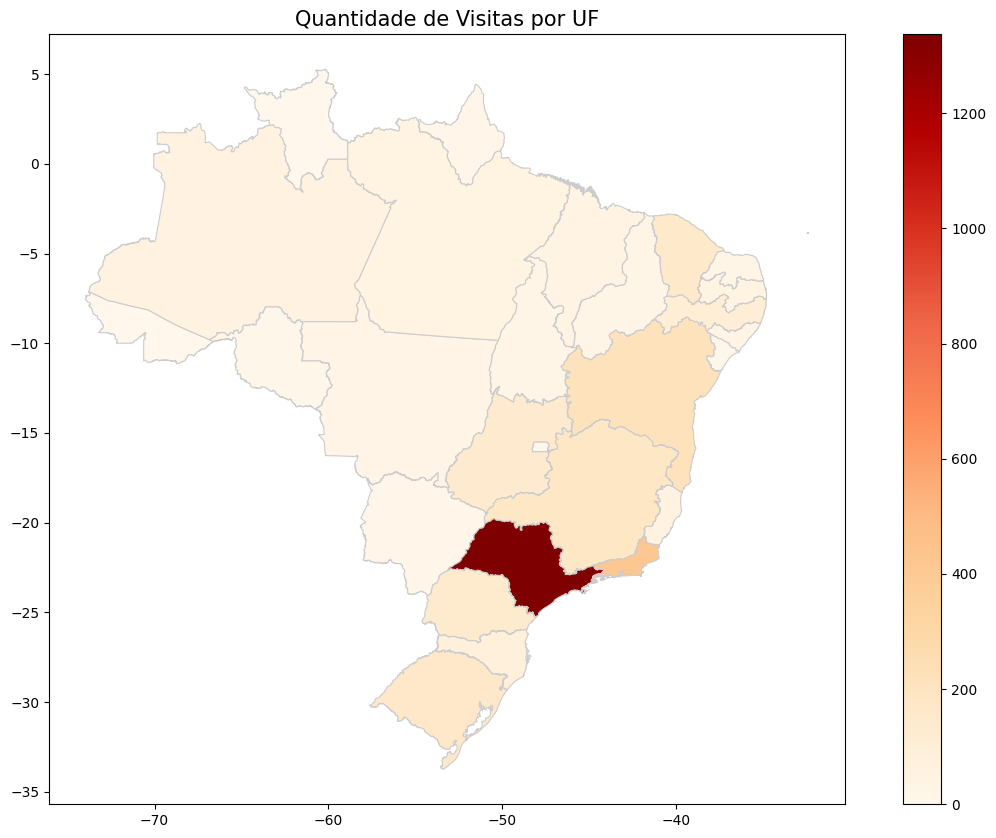

In [189]:
import pandas as pd
import json
import matplotlib.pyplot as plt

caminho_json = "/home/joyce/lappis/documentacao/docs/engd/data/region.json"
caminho_shapefile = "/home/joyce/lappis/documentacao/docs/engd/shapefile/estados_2010.shp"

with open(caminho_json, 'r') as file:
    dados_json = json.load(file)

df = pd.DataFrame(dados_json, columns=["region", "country", "nb_visits"])

df_br = df[df["country"] == "br"]

gdf_estados = gpd.read_file(caminho_shapefile)

gdf_estados = gdf_estados.merge(df_br, left_on='sigla', right_on='region', how='left')

gdf_estados['nb_visits'] = gdf_estados['nb_visits'].fillna(0)

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
gdf_estados.plot(column='nb_visits', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

plt.title('Quantidade de Visitas por UF', fontdict={'fontsize': '15', 'fontweight' : '3'})

leg = ax.get_legend()
if leg:
    leg.set_bbox_to_anchor((1, 0.5))

plt.savefig("/home/joyce/lappis/documentacao/docs/engd/assets/uf.png")

plt.show()


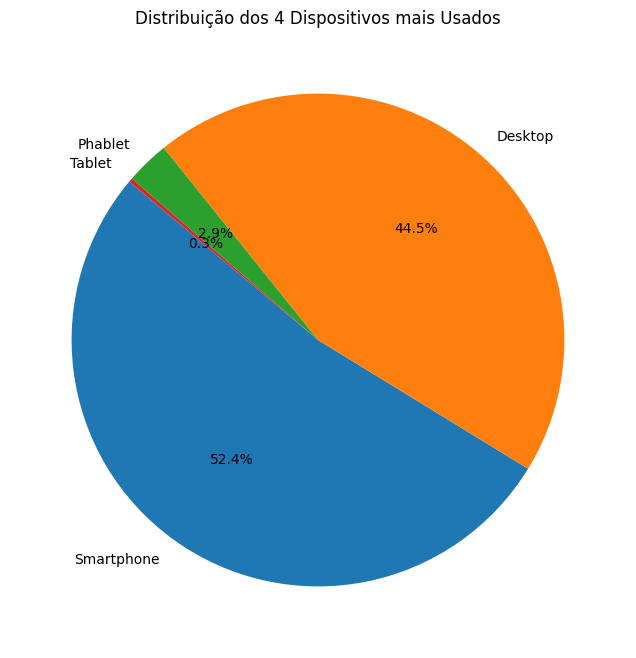

In [188]:
path_device = "/home/joyce/lappis/documentacao/docs/engd/data/device_type.json"

with open(path_device, 'r') as file:
    dados_json = json.load(file)

df_devices = pd.DataFrame(dados_json, columns=["label", "nb_visits"])

df_devices = df_devices.sort_values(by='nb_visits', ascending=False)

top_devices = df_devices.head(4)

plt.figure(figsize=(8, 8))
plt.pie(top_devices['nb_visits'], labels=top_devices['label'], autopct='%1.1f%%', startangle=140)

plt.title('Distribuição dos 4 Dispositivos mais Usados')
plt.savefig("/home/joyce/lappis/documentacao/docs/engd/assets/devices.png")

plt.show()


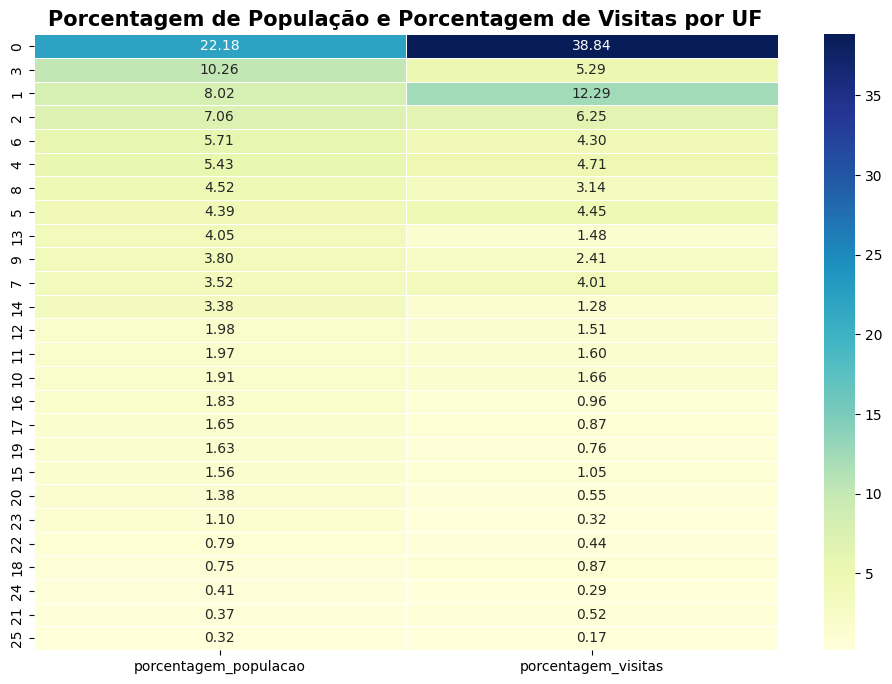

In [187]:
caminho_json_visitas = "/home/joyce/lappis/documentacao/docs/engd/data/region.json"
caminho_json_populacao = "/home/joyce/lappis/documentacao/docs/engd/data/populacao.json"

with open(caminho_json_visitas, 'r') as file:
    dados_json_visitas = json.load(file)

with open(caminho_json_populacao, 'r') as file:
    dados_json_populacao = json.load(file)

df_visitas = pd.DataFrame(dados_json_visitas, columns=["region", "country", "nb_visits"])
df_populacao = pd.DataFrame(dados_json_populacao).transpose()

df_br_visitas = df_visitas[df_visitas["country"] == "br"]


df_br = df_br.rename(columns={'region': 'UF'})

df_completo = pd.merge(df_br, df_populacao, on="UF", how="inner")

total_visitas = df_completo['nb_visits'].sum()
total_populacao = df_completo['populacao'].sum()

df_completo['porcentagem_visitas'] = (df_completo['nb_visits'] / total_visitas) * 100
df_completo['porcentagem_populacao'] = (df_completo['populacao'] / total_populacao) * 100

df_completo = df_completo.sort_values(by="porcentagem_populacao", ascending=False)

df_completo['porcentagem_populacao'] = df_completo['porcentagem_populacao'].astype(float)
df_completo['porcentagem_visitas'] = df_completo['porcentagem_visitas'].astype(float)

df_heatmap = df_completo[['porcentagem_populacao', 'porcentagem_visitas']]

plt.figure(figsize=(12, 8))
sns.heatmap(df_heatmap, annot=True, cmap="YlGnBu", fmt=".2f", linewidths=.5, )

plt.title('Porcentagem de População e Porcentagem de Visitas por UF', fontsize=15, fontweight='bold')

plt.savefig("/home/joyce/lappis/documentacao/docs/engd/assets/proporcao.png")

plt.show()


In [24]:
import yaml

# Caminho do arquivo YAML
yaml_file_path = '/home/joyce/lappis/documentacao/docs/engd/textos.yml'
# Caminho para salvar o arquivo Markdown
markdown_file_path = '/home/joyce/lappis/documentacao/docs/engd/relatorio.md'

# Função para carregar o arquivo YAML
def carregar_dados_yaml(caminho):
    with open(caminho, 'r') as arquivo:
        dados_yaml = yaml.safe_load(arquivo)
    return dados_yaml

# Função para converter dados YAML para Markdown com base nos índices
def converter_para_markdown(dados_yaml):
    markdown = ""
    for secao, paragrafos in dados_yaml.items():
        markdown += f"## {secao.capitalize()}\n\n"
        for indice, paragrafo in enumerate(paragrafos):
            markdown += f"{indice + 1}. {paragrafo.strip()}\n\n"
    return markdown

# Carregar dados YAML do arquivo
dados_yaml = carregar_dados_yaml(yaml_file_path)

# Especificar as seções que você deseja processar (introducao, dados_gerais, dados_acesso)
secoes_desejadas = ['introducao', 'dados_gerais', 'dados_acesso']

# Filtrar e converter para Markdown apenas as seções desejadas
markdown_final = converter_para_markdown({secao: dados_yaml[secao] for secao in secoes_desejadas})

# Salvar o Markdown em um arquivo
with open(markdown_file_path, 'w') as arquivo_markdown:
    arquivo_markdown.write(markdown_final)



Arquivo Markdown salvo em: /home/joyce/lappis/documentacao/docs/engd/relatorio.md


#### markdown
